# 6. Neural Network 
## 6.1 CNN for sentiment analysis

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# set parameters:
#max_features = 1000 # max number of words in the corpus
#maxlen = 400 # max number of words in the review
batch_size = 32
embedding_dims = 50 # emddeding for each word
filters = 250
kernel_size = 3 #size of the 1D conv. layer
hidden_dims = 250 # number of dimensions
epochs = 2

# set parameters:
max_features = 1000 # max number of words in the corpus
maxlen = 400 # max number of words in the review

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 5000
#EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
df=pd.read_csv(r'C:\Users\liewm\Documents\BT4222 Mining Web Data\Project\latest.csv')
df.dropna()
df = df.dropna()
df=df.drop(columns=['Unnamed: 0'])
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.head(2))

Shape of dataset  (861076, 2)
                                        Stem_Summary  score
0                     only park outside hotel beauti      1
1   no real complaints hotel great great location...      1


In [5]:
texts=df.Stem_Summary
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))


Number of Unique Tokens 80132


In [6]:
max_features=len(tokenizer.word_index)+1

In [9]:
print('The longest string is: ',int(df['Stem_Summary'].str.encode(encoding='utf-8').str.len().max()))

The longest string is:  1863


In [10]:
from sklearn.model_selection import train_test_split
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = df.score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


In [12]:
print('Build model...')
model = Sequential()


# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(input_dim=max_features,
                    output_dim=embedding_dims,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(x_test, y_test))

epochs = 2
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])




Build model...
Train on 551088 samples, validate on 137772 samples
Epoch 1/2
551088/551088 [==============================] - 32018s 58ms/step - loss: 0.2179 - acc: 0.9141 - val_loss: 0.1758 - val_acc: 0.9341
Epoch 2/2
551088/551088 [==============================] - 22919s 42ms/step - loss: 0.1751 - acc: 0.9357 - val_loss: 0.1655 - val_acc: 0.9387


In [13]:
accr = model.evaluate(X_test,y_test,verbose=0)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.166
  Accuracy: 0.939


In [18]:
scores = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

KeyboardInterrupt: 

In [ ]:
# Results - Confusion Matrix
y_test_pred = model.predict_classes(X_test)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()


# Plot ROC curve
y_test_pred_probs = model.predict(X_test)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
fpr, tpr, threshold = roc_curve(y_test, y_test_pred_probs)
roc_auc = auc(fpr, tpr)
    
#Plot ROC

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

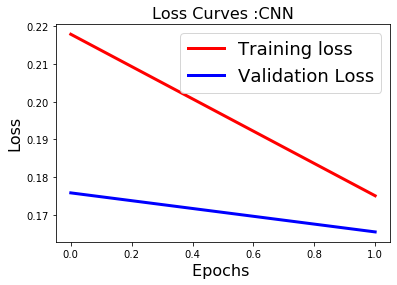

In [14]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

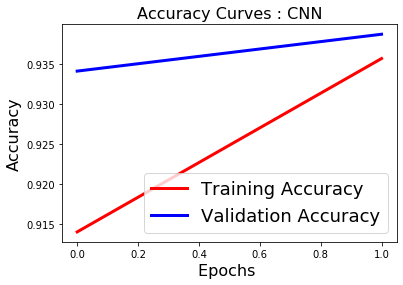

In [15]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()